In [1]:
from os import environ, path
import pandas as pd
import xgboost

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

DATA_PATH = environ.get('DATA_PATH', '../data/')
MODEL_PATH = environ.get('MODEL_PATH', '../models/')

In [2]:
# 0 - for repeatable testing
# None - for default random
random_state = 0

In [3]:
cleaned_data = pd.read_csv(path.join(DATA_PATH, 'cleaned_data.csv'), index_col=0).reset_index(drop=True)
cleaned_data

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,dayofyear_sin,dayofweek_cos,dayofweek_sin,is_weekend,days_until_holidays,days_after_holidays,is_holiday,minute_of_day_cos,minute_of_day_sin,duration
0,4,3441,4,557,1239,33,14,21,446,861.0,...,-0.128748,-0.900969,-0.433884,False,10,18,False,0.913545,-0.406737,3779.0
1,1,1900,1,1400,1400,1,2,2,446,690.0,...,-0.128748,0.623490,0.781831,False,6,22,False,0.841039,-0.540974,4024.0
2,4,4771,3,820,1604,8,6,18,446,289.0,...,-0.128748,1.000000,0.000000,False,0,0,True,0.998848,0.047978,1586.0
3,1,1525,1,1525,1525,5,6,8,446,795.0,...,-0.128748,-0.900969,0.433884,False,4,24,False,0.587785,0.809017,2273.0
4,2,3620,2,1425,2195,5,5,7,446,205.0,...,-0.128748,0.623490,0.781831,False,20,8,False,0.838671,0.544639,2988.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176448,3,1389,3,345,649,17,17,23,251,331.0,...,-0.128748,0.623490,0.781831,False,97,1,False,0.996566,0.082808,3907.0
176449,6,3010,4,405,825,12,11,14,251,915.0,...,-0.128748,-0.900969,-0.433884,False,3,25,False,0.999990,0.004363,3383.0
176450,5,1836,3,300,399,39,41,40,251,795.0,...,-0.128748,-0.222521,-0.974928,True,23,5,False,0.317305,0.948324,3008.0
176451,1,1175,1,535,535,7,7,12,446,384.0,...,-0.128748,0.623490,-0.781831,True,15,13,False,0.078459,-0.996917,3907.0


## Dataset preparation

In [4]:
y = cleaned_data.reindex(columns=['duration'])
assert y.isnull().any().any() == False

In [5]:
x = cleaned_data.drop(columns=['duration'])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=random_state)

## Baseline model

In [94]:
basic_x = cleaned_data.reindex(columns=[
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration'
])

In [95]:
basic_x_train, basic_x_test, basic_y_train, basic_y_test = \
    train_test_split(basic_x, y, test_size=0.2, shuffle=True, random_state=random_state)

In [96]:
model = xgboost.XGBRegressor()
history = best_model.fit(
    basic_x_train, basic_y_train,
    eval_set=[(basic_x_test, basic_y_test)],
    eval_metric=['rmse', 'mae'], 
    early_stopping_rounds=10)

[0]	validation_0-rmse:2274.06641	validation_0-mae:2006.41003
Multiple eval metrics have been passed: 'validation_0-mae' will be used for early stopping.

Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-rmse:1752.94836	validation_0-mae:1413.58618
[2]	validation_0-rmse:1425.69336	validation_0-mae:1042.18591
[3]	validation_0-rmse:1231.72083	validation_0-mae:848.29474
[4]	validation_0-rmse:1120.17017	validation_0-mae:758.16284
[5]	validation_0-rmse:1058.68909	validation_0-mae:720.54663
[6]	validation_0-rmse:1021.47345	validation_0-mae:703.12170
[7]	validation_0-rmse:1001.41620	validation_0-mae:697.46704
[8]	validation_0-rmse:988.44055	validation_0-mae:695.27631
[9]	validation_0-rmse:980.69324	validation_0-mae:695.05774
[10]	validation_0-rmse:975.43524	validation_0-mae:694.91290
[11]	validation_0-rmse:972.69733	validation_0-mae:695.40906
[12]	validation_0-rmse:965.25824	validation_0-mae:691.48816
[13]	validation_0-rmse:962.89722	validation_0-mae:691.14087
[1

In [97]:
history.best_score

675.198792

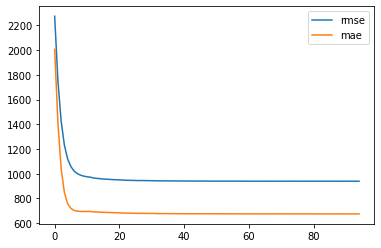

In [98]:
pd.DataFrame(history.evals_result()['validation_0']).plot()

## Model tuning

In [44]:
model = xgboost.XGBRegressor()
params={
    'booster': ['gbtree'], #['dart'] - best but shap not supported, #['gbtree', 'gblinear', 'dart'],
    'objective': ['reg:gamma'], #['reg:squarederror', 'reg:squaredlogerror', 'reg:logistic', 'reg:gamma'],
    'max_depth': [7], #[3, 4, 5, 6, 7, 10, 15], #--
    'learning_rate': [0.05, 0.1, 0.15], #--
    'n_estimators': [300, 350, 400],
#     'min_child_weight': [1, 10], #++
#     'colsample_bytree': [0.8],
#     'subsample': [0.75], 
#     'reg_alpha': [0],
#     'reg_lambda': [2], 
#     'gamma' : [0],
}
cv = KFold(5, shuffle=True, random_state=random_state)
rs = GridSearchCV(
    model,
    params,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=5,
    verbose=10)

rs.fit( 
    x, 
    y, 
    verbose=False)
print('best params:', rs.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  8.7min
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 19.9min
[Parallel(n_jobs=5)]: Done  41 out of  45 | elapsed: 26.3min remaining:  2.6min
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed: 26.5min finished


best params: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 350, 'objective': 'reg:gamma'}


## Model training

In [7]:
# best_params = {'objective': 'reg:gamma', 'max_depth': 6, 'n_estimators': 200}
best_params = {
    'booster': 'gbtree', 
    'objective': 'reg:gamma',
    'max_depth': 7,
    'learning_rate': 0.15,
    'n_estimators': 350,
}

In [8]:
model = xgboost.XGBRegressor(**best_params)
history = model.fit(
    x_train, y_train,
    eval_set=[(x_test, y_test)],
    eval_metric=['mae', 'rmse'], 
    early_stopping_rounds=int(best_params.get('n_estimators', 100) * 0.1))

[0]	validation_0-mae:2862.93433	validation_0-rmse:3070.15894
Multiple eval metrics have been passed: 'validation_0-rmse' will be used for early stopping.

Will train until validation_0-rmse hasn't improved in 35 rounds.
[1]	validation_0-mae:2862.89624	validation_0-rmse:3070.06885
[2]	validation_0-mae:2862.75781	validation_0-rmse:3069.96680
[3]	validation_0-mae:2862.71118	validation_0-rmse:3069.84839
[4]	validation_0-mae:2862.68945	validation_0-rmse:3069.71143
[5]	validation_0-mae:2862.63184	validation_0-rmse:3069.55444
[6]	validation_0-mae:2862.45728	validation_0-rmse:3069.36816
[7]	validation_0-mae:2861.89722	validation_0-rmse:3069.15259
[8]	validation_0-mae:2861.71045	validation_0-rmse:3068.89941
[9]	validation_0-mae:2861.63110	validation_0-rmse:3068.61328
[10]	validation_0-mae:2860.93188	validation_0-rmse:3068.27441
[11]	validation_0-mae:2860.69287	validation_0-rmse:3067.87866
[12]	validation_0-mae:2859.94653	validation_0-rmse:3067.42603
[13]	validation_0-mae:2859.68115	validation_0

[132]	validation_0-mae:619.16412	validation_0-rmse:868.27856
[133]	validation_0-mae:619.10040	validation_0-rmse:868.24634
[134]	validation_0-mae:619.00635	validation_0-rmse:868.12079
[135]	validation_0-mae:618.94794	validation_0-rmse:868.09827
[136]	validation_0-mae:618.86529	validation_0-rmse:867.98267
[137]	validation_0-mae:618.76764	validation_0-rmse:867.84296
[138]	validation_0-mae:618.74457	validation_0-rmse:867.85107
[139]	validation_0-mae:618.64654	validation_0-rmse:867.75384
[140]	validation_0-mae:618.59149	validation_0-rmse:867.64514
[141]	validation_0-mae:618.53729	validation_0-rmse:867.53601
[142]	validation_0-mae:618.22620	validation_0-rmse:867.09332
[143]	validation_0-mae:618.13721	validation_0-rmse:866.97345
[144]	validation_0-mae:617.90680	validation_0-rmse:866.60284
[145]	validation_0-mae:617.66003	validation_0-rmse:866.37872
[146]	validation_0-mae:617.59839	validation_0-rmse:866.31317
[147]	validation_0-mae:617.56543	validation_0-rmse:866.25464
[148]	validation_0-mae:6

[267]	validation_0-mae:613.08008	validation_0-rmse:861.55438
[268]	validation_0-mae:613.02850	validation_0-rmse:861.55090
[269]	validation_0-mae:613.02478	validation_0-rmse:861.53339
[270]	validation_0-mae:613.02539	validation_0-rmse:861.52661
[271]	validation_0-mae:613.07385	validation_0-rmse:861.56763
[272]	validation_0-mae:613.06641	validation_0-rmse:861.56793
[273]	validation_0-mae:613.06293	validation_0-rmse:861.62506
[274]	validation_0-mae:613.02777	validation_0-rmse:861.57001
[275]	validation_0-mae:612.98834	validation_0-rmse:861.57361
[276]	validation_0-mae:612.92944	validation_0-rmse:861.56024
[277]	validation_0-mae:612.90753	validation_0-rmse:861.53516
[278]	validation_0-mae:612.93451	validation_0-rmse:861.54913
[279]	validation_0-mae:612.93323	validation_0-rmse:861.54486
[280]	validation_0-mae:612.92151	validation_0-rmse:861.52069
[281]	validation_0-mae:612.94812	validation_0-rmse:861.53546
[282]	validation_0-mae:612.81763	validation_0-rmse:861.39221
[283]	validation_0-mae:6

## Model evaluation

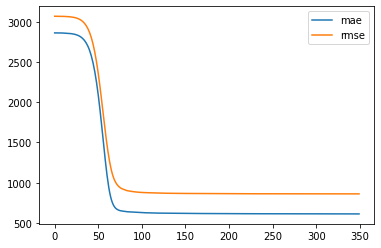

In [9]:
pd.DataFrame(history.evals_result()['validation_0']).plot()

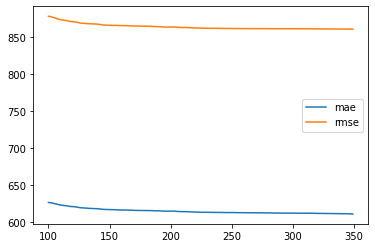

In [10]:
pd.DataFrame(history.evals_result()['validation_0']).iloc[100:].plot.line()

In [11]:
y_true = y_test
y_pred = model.predict(x_test)

print('RMSE: ', np.sqrt(mean_squared_error(y_true, y_pred)))
print('MAE: ', mean_absolute_error(y_true, y_pred))

RMSE:  860.8032767477448
MAE:  611.5749419191452


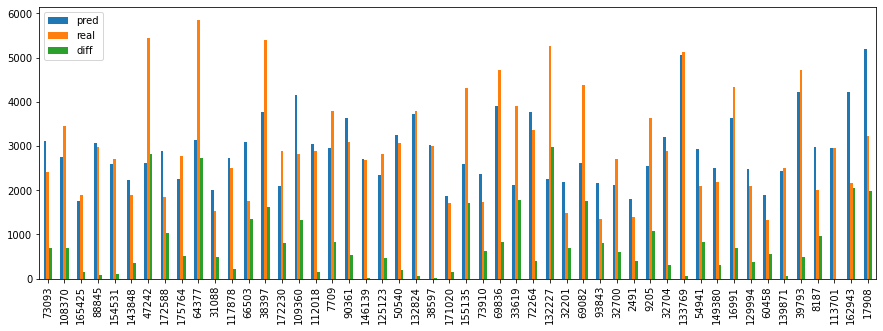

In [12]:
pd.DataFrame({
    'pred': y_pred,
    'real': y_true.duration,
    'diff': (y_pred - y_true.duration).abs(),
}).iloc[:50].plot.bar(figsize=(15,5))

## Features importance

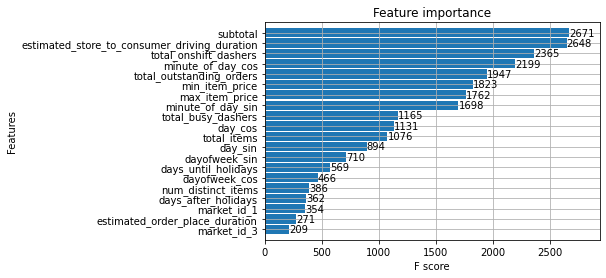

In [13]:
xgboost.plot_importance(model, height=0.9, max_num_features=20)

In [14]:
import shap
shap.initjs()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


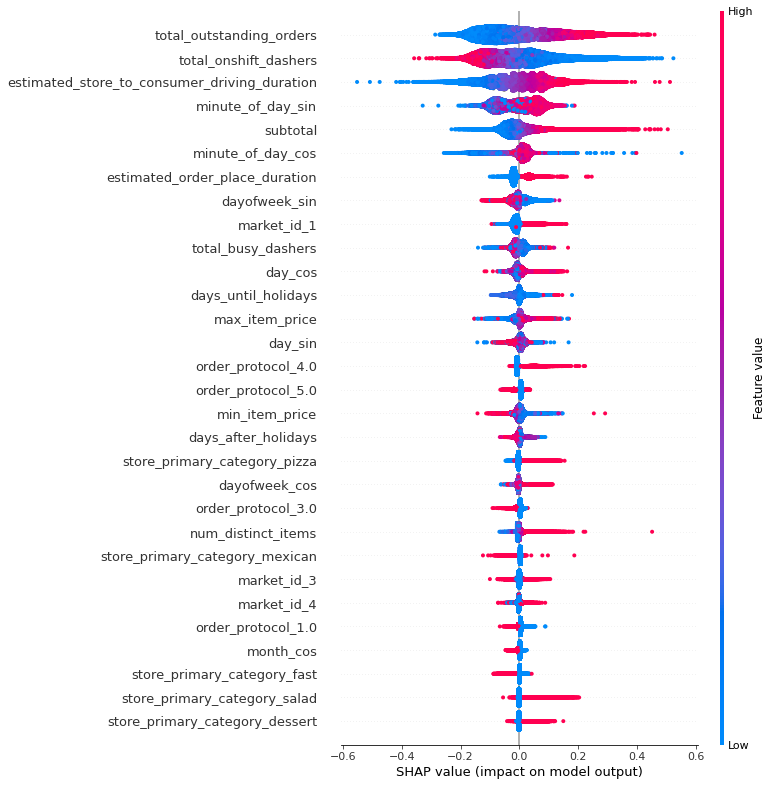

In [15]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x, max_display=30)

## Model save

In [16]:
import pickle
import datetime

In [17]:
used_encoders_file_path = path.join(DATA_PATH, 'cleaned_data_encoders.pickle')
used_encoders = pickle.load(open(used_encoders_file_path, "rb"))

In [18]:
model_file_name = f'xgboost_model_with_encoders_{datetime.datetime.utcnow().isoformat()}.pickle'
model_file_path = path.join(MODEL_PATH, model_file_name)

structured_model = {
    'model': model,
    'encoders': used_encoders,
}
pickle.dump(structured_model, open(model_file_path, "wb"))
print('Saved as: ', f'\'{model_file_path}\'')

Saved as:  '../models/xgboost_model_with_encoders_2020-03-12T14:47:23.005373.pickle'


In [19]:
pickle.load(open(model_file_path, "rb"))

{'model': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.15, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=350, n_jobs=0, num_parallel_tree=1,
              objective='reg:gamma', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None),
 'encoders': {'store_primary_category': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                handle_unknown='ignore', sparse=True),
  'market_id': OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                handle_unknown='ignore', sparse=True),
  'order_protocol': OneHotEncoder(categories='auto', drop